In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson, cumulative_trapezoid
from imripy import constants as c, kepler, merger_system as ms, halo, inspiral, plot_utils as pu, waveform, detector
from imripy.inspiral import forces
from imripy.kepler import KeplerOrbit
import plotting
import copy
import common

This notebook explores wet inspirals, that means a central MBH with an accretion disk. The possible interactions are gas dynamical friction, Type--I torque, and geometric drag. Additionally, can have stellar distribution and DM spikes around it.
It explores the phase space flow of $(a,e)$, shows an example inspiral, and calculates the dephasing and deshifting.

In [2]:
# Example system
m1 = 1e5 * c.solar_mass_to_pc
m2 = 10. * c.solar_mass_to_pc
D_l = 5e8 # 50 Mpc

hs = ms.HostSystem(m1, D_l=D_l)

In [3]:
from collections.abc import Sequence
issequence = lambda x: isinstance(x, Sequence)

# Wet Inspirals

## Phase Space Flow

In [7]:
# GW loss
gw = inspiral.forces.GWLoss()
# Stellar Distribution
stellarHalo, stellarDiffusion = common.StellarDistribution(hs, E_m_s=m2)

# Accretion Disk
dmDisk, gdf_dm = common.AccretionDisk(hs)
gt1_dm = forces.GasInteraction(disk=dmDisk) # Type 1 interaction

# DM spikes
spike_73, df_73 = common.DMSpike(hs, 7./3.)
spike_32, df_32 = common.DMSpike(hs, 3./2.)

In [ ]:
opt_gw_gdf = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, gdf_dm], 
                                                  considerRelativeVelocities=True)
# ignore_32, is subdominant either way
opt_gw_gdf_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, gdf_dm, df_73], 
                                                  considerRelativeVelocities=True)

opt_gw_sd_gdf = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm], 
                                                  considerRelativeVelocities=True)

opt_gw_sd_gdf_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, stellarDiffusion, gdf_dm, df_73], 
                                                  considerRelativeVelocities=True)


In [ ]:
fig,axs = plt.subplots(2,2, figsize=(12,12), sharex='all', sharey='all')
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.- np.geomspace(1e-4, 1., 25)


ko = KeplerOrbit(hs, m2, 0.)

pu.streamline(axs[0,0], hs, opt_gw_sd_gdf, ko, a_grid, e_grid)
axs[0,0].set_title(r"SD+GDF")
pu.streamline(axs[0,1], hs, opt_gw_sd_gdf_73, ko, a_grid, e_grid)
axs[0,1].set_title(r"SD+GDF+$\gamma=7/3$")

ko = KeplerOrbit(hs, m2, 0., inclination_angle=np.pi) # retrograde

pu.streamline(axs[1,0], hs, opt_gw_sd_gdf, ko, a_grid, e_grid)
pu.streamline(axs[1,1], hs, opt_gw_sd_gdf_73, ko, a_grid, e_grid)

axs[1,0].set_xlabel(r"$\log_{10} 1-e$"); 
axs[1,1].set_xlabel(r"$\log_{10} 1-e$"); 
axs[0,0].set_ylabel(r"$\log_{10} a/r_{isco}$")
axs[1,0].set_ylabel(r"$\log_{10} a/r_{isco}$")
axs[0,1].set_ylabel("prograde"); axs[0,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel("retrograde"); axs[1,1].yaxis.set_label_position("right")

fig.savefig("plots/psf_wet.pdf", bbox_inches="tight")

In [ ]:
# without SD

fig,axs = plt.subplots(2,2, figsize=(12,12), sharex='all', sharey='all')
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.- np.geomspace(1e-4, 1., 25)


ko = KeplerOrbit(hs, m2, 0.)

pu.streamline(axs[0,0], hs, opt_gw_gdf, ko, a_grid, e_grid)
axs[0,0].set_title(r"GDF")
pu.streamline(axs[0,1], hs, opt_gw_gdf_73, ko, a_grid, e_grid)
axs[0,1].set_title(r"GDF+$\gamma=7/3$")

ko = KeplerOrbit(hs, m2, 0., inclination_angle=np.pi) # retrograde

pu.streamline(axs[1,0], hs, opt_gw_gdf, ko, a_grid, e_grid)
pu.streamline(axs[1,1], hs, opt_gw_gdf_73, ko, a_grid, e_grid)

axs[1,0].set_xlabel(r"$\log_{10} 1-e$"); 
axs[1,1].set_xlabel(r"$\log_{10} 1-e$"); 
axs[0,0].set_ylabel(r"$\log_{10} a/r_{isco}$")
axs[1,0].set_ylabel(r"$\log_{10} a/r_{isco}$")
axs[0,1].set_ylabel("prograde"); axs[0,1].yaxis.set_label_position("right")
axs[1,1].set_ylabel("retrograde"); axs[1,1].yaxis.set_label_position("right")

#fig.savefig("plots/psf_wet.pdf", bbox_inches="tight")

## Example Inspirals with Torque-I

In [8]:
a0 = 1e4 * hs.r_isco
e0 = 0.  # circular

inclination_angle = 0. # prograde
k0 = kepler.KeplerOrbit(hs, m2, a0, e0, inclination_angle=inclination_angle)

In [9]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

In [10]:
opt_gt1 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, gt1_dm], accuracy=1e-11)


t_t1 = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt_gt1) / gt1_dm.dE_dt(hs, k0, opt=opt_gt1))

ev_gt1 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*np.min([t_t1, t_GW]), opt=opt_gt1)

Evolving from  10000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.9299s real time


In [11]:
opt_gt1_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, gt1_dm, df_32],
                                                    accuracy=1e-11)

ev_gt1_32 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_gt1.t[-1], opt=opt_gt1_32)

Evolving from  10000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 9.1658s real time


In [12]:
opt_gt1_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, gt1_dm, df_73],
                                                  accuracy=1e-11)


ev_gt1_73 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_gt1.t[-1], opt=opt_gt1_73)

Evolving from  10000.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 1.0e-11
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 3.3359s real time


In [13]:
ev_gt1.f = np.sqrt(ev_gt1.m_tot/ev_gt1.a**3) / 2. / np.pi
ev_gt1_32.f = np.sqrt(ev_gt1_32.m_tot/ev_gt1_32.a**3) / 2. / np.pi
ev_gt1_73.f = np.sqrt(ev_gt1_73.m_tot/ev_gt1_73.a**3) / 2. / np.pi

ev_gt1.N = cumulative_trapezoid(ev_gt1.f, ev_gt1.t, initial=0)
ev_gt1_32.N = cumulative_trapezoid(ev_gt1_32.f, ev_gt1_32.t, initial=0)
ev_gt1_73.N = cumulative_trapezoid(ev_gt1_73.f, ev_gt1_73.t, initial=0)

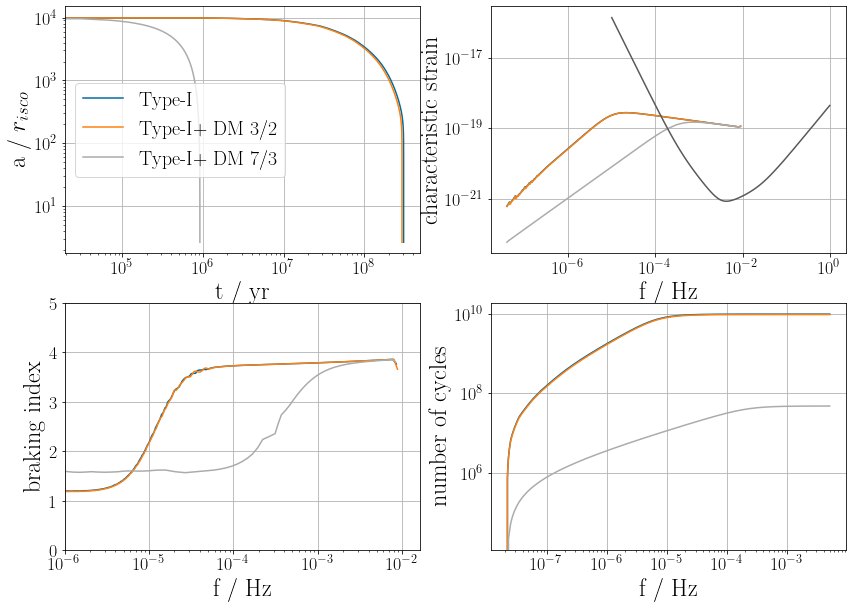

In [26]:
fig, axs = plt.subplots(2,2, figsize=(14,10))

l0=pu.plotEvolution(hs, ev_gt1, ax_a=axs[0,0], ax_n=axs[1,0], label='Type-I')
l1=pu.plotEvolution(hs, ev_gt1_32, ax_a=axs[0,0], ax_n=axs[1,0], label='Type-I+ DM 3/2')
l2=pu.plotEvolution(hs, ev_gt1_73, ax_a=axs[0,0], ax_n=axs[1,0], label='Type-I+ DM 7/3')

pu.plotGWcharacteristicStrain(hs, ev_gt1, axs[0,1], harmonics=[2])
axs[1,1].loglog(ev_gt1.f / c.hz_to_invpc, ev_gt1.N, color=l0.get_c())

pu.plotGWcharacteristicStrain(hs, ev_gt1_32, axs[0,1], harmonics=[2])
axs[1,1].loglog(ev_gt1_32.f / c.hz_to_invpc, ev_gt1_32.N, color=l1.get_c())

pu.plotGWcharacteristicStrain(hs, ev_gt1_73, axs[0,1], harmonics=[2])
axs[1,1].loglog(ev_gt1_73.f / c.hz_to_invpc, ev_gt1_73.N, color=l2.get_c())

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axs[0,1].loglog(f_gw/c.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
axs[0,1].set_xlabel("f / Hz"); axs[0,1].set_ylabel("characteristic strain")

axs[0,0].set_xlabel("t / yr"); axs[0,0].set_ylabel("a / $r_{isco}$")
axs[0,0].legend()

axs[1,0].set_xscale('log'); axs[1,0].set_xlabel("f / Hz"); axs[1,0].set_ylabel("braking index")
axs[1,0].set_xlim(left=1e-6); axs[1,0].set_ylim(bottom=0, top=5)

axs[1,1].set_xlabel("f / Hz"); axs[1,1].set_ylabel("number of cycles")


for ax in axs.flatten():
    ax.grid()
fig.savefig(f"plots/ev_wet_{m1/c.solar_mass_to_pc:.0e}.pdf", bbox_inches="tight")

In [15]:
dE_df_gt1_32 = common.energy_loss(hs, ev_gt1_32, df_32, opt_gt1_32)
r_df_32 = dE_df_gt1_32 / spike_32.potentialEnergy(spike_32.r_spike)
print(r_df_32)

1.6470052249068665


In [16]:
dE_df_gt1_73 = common.energy_loss(hs, ev_gt1_73, df_73, opt_gt1_73)
r_df_73 = dE_df_gt1_73 / spike_73.potentialEnergy(spike_73.r_spike)
print(r_df_73)

0.7208855840361718


## with stellar diffusion

In [ ]:
a0 = 1e4 * hs.r_isco
e0 = 0.  # circular

inclination_angle = 0. # prograde
k0 = kepler.KeplerOrbit(hs, m2, a0, e0, inclination_angle=inclination_angle)

In [ ]:
stellarHalo, stellarDiffusion = common.StellarDistributionAna(hs)

In [ ]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

k = 0.34
sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s**2 / stellarDiffusion.CoulombLogarithm * (1.-e0))
print(t_GW, t_AM)

In [ ]:
opt_sd_gt1 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gt1_dm, stellarDiffusion}, accuracy=1e-11)

hs.halo = stellarHalo # We ignore the mass of the accretion disk

ev_sd_gt1 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*np.min([t_AM, t_GW]), opt=opt_sd_gt1)

In [ ]:
opt_sd_gt1_32 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gt1_dm, stellarDiffusion, df_32},
                                                    accuracy=1e-11)
hs.halo = halo.CombinedHalo([stellarHalo, spike_32])

ev_sd_gt1_32 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_sd_gt1.t[-1], opt=opt_sd_gt1_32)

In [ ]:
opt_sd_gt1_73 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gt1_dm, stellarDiffusion, df_73},
                                                  accuracy=1e-11)

hs.halo = halo.CombinedHalo([stellarHalo, spike_73])

ev_sd_gt1_73 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_sd_gt1.t[-1], opt=opt_sd_gt1_73)

In [ ]:
ev_sd_gt1.f = np.sqrt(ev_sd_gt1.m_tot/ev_sd_gt1.a**3) / 2. / np.pi
ev_sd_gt1_32.f = np.sqrt(ev_sd_gt1_32.m_tot/ev_sd_gt1_32.a**3) / 2. / np.pi
ev_sd_gt1_73.f = np.sqrt(ev_sd_gt1_73.m_tot/ev_sd_gt1_73.a**3) / 2. / np.pi

ev_sd_gt1.N = cumulative_trapezoid(ev_sd_gt1.f, ev_sd_gt1.t, initial=0)
ev_sd_gt1_32.N = cumulative_trapezoid(ev_sd_gt1_32.f, ev_sd_gt1_32.t, initial=0)
ev_sd_gt1_73.N = cumulative_trapezoid(ev_sd_gt1_73.f, ev_sd_gt1_73.t, initial=0)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(18,12))

l0=pu.plotEvolution(hs, ev_sd_gt1, ax_a=axs[0,0], ax_n=axs[1,0], label='SD+Type-I')
l1=pu.plotEvolution(hs, ev_sd_gt1_32, ax_a=axs[0,0], ax_n=axs[1,0], label='SD+Type-I+ DM 3/2')
l2=pu.plotEvolution(hs, ev_sd_gt1_73, ax_a=axs[0,0], ax_n=axs[1,0], label='SD+Type-I+ DM 7/3')

pu.plotGWcharacteristicStrain(hs, ev_sd_gt1, axs[0,1], harmonics=[2], label='SD+AC')
axs[1,1].loglog(ev_sd_gt1.f / c.hz_to_invpc, ev_sd_gt1.N, color=l0.get_c())

pu.plotGWcharacteristicStrain(hs, ev_sd_gt1_32, axs[0,1], harmonics=[2], label='SD+AC+DM 3/2')
axs[1,1].loglog(ev_sd_gt1_32.f / c.hz_to_invpc, ev_sd_gt1_32.N, color=l1.get_c())

pu.plotGWcharacteristicStrain(hs, ev_sd_gt1_73, axs[0,1], harmonics=[2], label='SD+AC+DM 7/3')
axs[1,1].loglog(ev_sd_gt1.f / c.hz_to_invpc, ev_sd_gt1.N, color=l2.get_c())

#pu.plotDeltaN(hs, ev_sd_gt1, ev_sd_gt1_32, axs[3], label='SD+AC+DM 3/2',color=l1.get_c(), plotFgw5year=True)
#pu.plotDeltaN(hs, ev_sd_gt1, ev_sd_gt1_73, axs[3], label='SD+AC+DM 7/3',color=l2.get_c(), plotFgw5year=True)


#axs[0].legend();  axs[0].set_xlim(right=1.1); axs[0].set_xlabel("1-e"); axs[0].set_ylabel("a / $r_{isco}$")

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axs[0,1].loglog(f_gw/c.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
axs[0,1].set_xlabel("f / Hz"); axs[0,1].set_ylabel("characteristic strain")

axs[0,0].set_xlabel("t / yr"); axs[0,0].set_ylabel("a / $r_{isco}$")
axs[0,0].legend()

axs[1,0].set_xscale('log'); axs[1,0].set_xlabel("f / Hz"); axs[1,0].set_ylabel("breaking index")

axs[1,1].set_xlabel("f / Hz"); axs[1,1].set_ylabel("number of cycles")


for ax in axs.flatten():
    ax.grid()
#fig.savefig(f"plots/ev_wet_sd_{m1/c.solar_mass_to_pc:.0e}.pdf", bbox_inches="tight")

In [ ]:
dE_df_gt1_32 = common.energy_loss(hs, ev_sd_gt1_32, df_32, opt_sd_gt1_32)
r_df_32 = dE_df_gt1_32 / spike_32.potentialEnergy(spike_32.r_spike)
print(r_df_32)

In [ ]:
dE_df_gt1_73 = common.energy_loss(hs, ev_sd_gt1_73, df_73, opt_sd_gt1_73)
r_df_73 = dE_df_gt1_73 / spike_73.potentialEnergy(spike_73.r_spike)
print(r_df_73)

## Dephasing

In [17]:
def timescales(hs, k0, df=None, opt=None):
    a0 = k0.a; e0 = k0.e; m1=hs.m1; m2=k0.m2; 
    t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2
    
    if not df is None:
        t_DF = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt) / df.dE_dt(hs, k0, opt=opt))
        return t_GW, t_DF
    return t_GW

In [18]:
def calc_dephasing(hss, df_base, df_compare, k0s, opts, hs_base=None, k0_base=None, opt_base=None, n=2):
    if not issequence(hss):
        hss = [copy.deepcopy(hss) for i in range(len(df_compare))]  # careful to make actual copies and not references
    if not issequence(k0s):
        k0s = [copy.deepcopy(k0s) for i in range(len(df_compare))]
    if not issequence(opts):
        opts = [copy.deepcopy(opts) for i in range(len(df_compare))]
    
    hs_base = hs_base or copy.deepcopy(hss[0])
    k0_base = k0_base or copy.deepcopy(k0s[0])
    opt_base = opt_base or copy.deepcopy(opts[0])
    opt_base.dissipativeForces = df_base
    for i, dfs in enumerate(df_compare):
        opts[i].dissipativeForces = df_base + dfs
    
    ts = np.array(timescales(hs_base, k0_base, df_base[1]))
    print(ts)
    ev_base = inspiral.Classic.Evolve(hs_base, k0_base, t_fin=1e2*np.min(ts), opt=opt_base)
    ev_base.f_gw, ev_base.N = waveform.N_cycles_n(2, hs_base, ev_base)
    _, ev_base.h_2p, ev_base.h_2c, __ = waveform.h_n(2, hs_base, ev_base)
    ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs_base, ev_base)
    N_0interp = interp1d(ev_base.f_gw, ev_base.N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    #pa_base = interp1d(ev_base.f_gw, ev_base.periapse_angle - ev_base.periapse_angle[-1], 
    #                       bounds_error=False, fill_value=(0.,0.))

    evs = [ev_base]
    for i,(hs, k0, opt) in enumerate(zip(hss, k0s, opts)):
        ts = list(timescales(hs, k0, opt.dissipativeForces[-1])); ts.append(ev_base.t[-1])
        print(i, ts)
        ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e1*np.min(ts), opt=opt)
        ev.f_gw, ev.N = waveform.N_cycles_n(2, hs, ev)
        ev.dN = ev.N - N_0interp(ev.f_gw)
        _, ev.h_2p, ev.h_2c, __ = waveform.h_n(2, hs, ev)
        ev.f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, ev)
        #ev.dperiapse_angle = np.abs((ev.periapse_angle - ev.periapse_angle[-1]) - pa_base(ev.f_gw))
        evs.append(ev)
    return evs

In [39]:
def compare_different_m1(m1, m2, D_l, acc=5e-13):
    hs_base = ms.HostSystem(m1, D_l=D_l)
    # GW loss
    #environmental effects
    gw = inspiral.forces.GWLoss()
    #stellarHalo, stellarDiffusion = common.StellarDistribution(hs_base, m2)
    dmDisk, _ = common.AccretionDisk(hs_base)
    gt1_dm = forces.GasInteraction(disk=dmDisk)
    spike_73, df_73 = common.DMSpike(hs_base, 7./3.)
    spike_32, df_32 = common.DMSpike(hs_base, 3./2.)
    
    # base
    #df_base = [gw, stellarDiffusion, gt1_dm]
    df_base = [gw, gt1_dm]
    opt_base = inspiral.Classic.EvolutionOptions(dissipativeForces=df_base, accuracy=acc)
    # different hs for different mass precession
    hs_32 = copy.deepcopy(hs_base); hs_73 = copy.deepcopy(hs_base); 
    hs_32.halo = spike_32; hs_73.halo = spike_73
    # initial orbit
    a0 = 1e2 * hs_base.r_isco
    e0 = 0.
    k0_base = kepler.KeplerOrbit(hs_base, m2, a0, e0)
    # calc dephasing
    evs = calc_dephasing([hs_32, hs_73], df_base, [[df_32], [df_73]], k0s=k0_base, opts=opt_base, hs_base=hs_base)
    # feedback ratio
    evs[1].r_df = common.energy_loss(evs[1].hs, evs[1], evs[1].options.dissipativeForces[-1], evs[1].options) / spike_32.potentialEnergy(spike_32.r_spike)
    evs[2].r_df = common.energy_loss(evs[2].hs, evs[2], evs[2].options.dissipativeForces[-1], evs[2].options) / spike_73.potentialEnergy(spike_73.r_spike)
    
    return evs

In [40]:
evs_wet_m1e5 = compare_different_m1(1e5*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

[ 2484011.21754651 15727390.45024074]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1765s real time
0 [2484011.217546508, 527856075.00573295, 119642.00849569158]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.8863s real time
1 [2484011.217546508, 5052.676637687681, 119642.00849569158]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.3661s real time


In [41]:
evs_wet_m1e4 = compare_different_m1(1e4*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

[ 24840.11217547 437427.70706567]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1841s real time
0 [24840.11217546508, 53877819.74564897, 1207.074437489565]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.7785s real time
1 [24840.11217546508, 163.9078941942494, 1207.074437489565]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.3674s real time


In [42]:
evs_wet_m1e3 = compare_different_m1(1e3*c.solar_mass_to_pc, 10.*c.solar_mass_to_pc, 5e8)

[  248.40112175 12117.35217792]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.1824s real time
0 [248.40112175465092, 5727686.7630075235, 12.005786968345193]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.8453s real time
1 [248.40112175465092, 5.699770433513788, 12.005786968345193]
Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {GWLoss, GasInteraction, DynamicalFriction, }, accuracy = 5.0e-13
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 1.4890s real time


In [56]:
def plot_observable_dephasing(ax, evs, labels, ax_di=None, min_dN=100.):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*np.abs(ev.h_2p) > Lisa.NoiseStrain(ev.f_gw)))

        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)-1- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dN[nobservable]), 
                        linestyle= '--')
            
        l, = ax.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dN[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        print(labels[i], ev.r_df)
        
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax, color=l.get_c(), marker='p',
                                            y=interp1d(ev.f_gw, np.abs(ev.dN)))
        
        if ax_di is not None:
            ddN_df = np.gradient(ev.dN, ev.f_gw)
            stop = np.where(np.abs(ev.dN) < min_dN)[0]
            stop = stop[0] if len(stop) > 0 else len(ddN_df)
            ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())
        

$m_1=10^5M_\odot, \gamma=3/2$ 0.02957575026849159
$m_1=10^5M_\odot, \gamma=7/3$ 0.5796096381566886
$m_1=10^4M_\odot, \gamma=3/2$ 0.1197227756024433
$m_1=10^4M_\odot, \gamma=7/3$ 9.085671660801935
$m_1=10^3M_\odot, \gamma=3/2$ 0.45662656566064574
$m_1=10^3M_\odot, \gamma=7/3$ 126.86425976273931


<ipython-input-56-d52b631c52b8>:34: RuntimeWarning: divide by zero encountered in divide
  ax_di.plot(ev.f_gw[:stop]/c.hz_to_invpc, (ddN_df/ev.dN * ev.f_gw)[:stop], color=l.get_c())


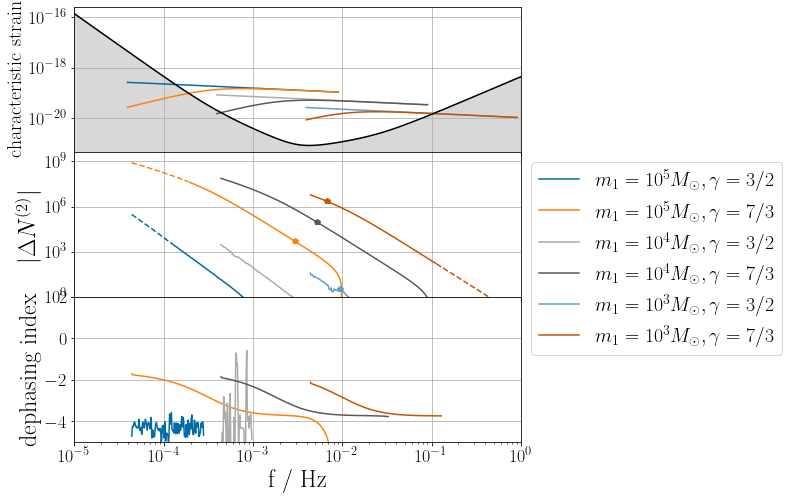

In [59]:
fig, axs = plt.subplots(3,1, sharex='all', figsize=(8,8))
Lisa = detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
for ev in evs_wet_m1e5[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_wet_m1e4[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_wet_m1e3[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])

axs[0].loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA', color='black')
axs[0].fill_between(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), color='gray', alpha=0.3)
    
plot_observable_dephasing(axs[1], evs_wet_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"], ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_wet_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"], ax_di=axs[2])
plot_observable_dephasing(axs[1], evs_wet_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"], ax_di=axs[2])
for ax in axs:
    ax.grid()

axs[0].set_ylabel("characteristic strain", fontsize=20)
axs[1].legend(bbox_to_anchor=(1.,1.), loc='upper left')
axs[1].set_ylim(bottom=1.); axs[1].set_xlim(left=1e-5, right=1)
axs[1].set_ylabel("$|\Delta N^{(2)}|$")
axs[2].set_ylabel("dephasing index")
axs[2].set_xlabel("f / Hz")
axs[2].set_ylim(-5,2)

fig.subplots_adjust(hspace=0.)
fig.savefig(f"plots/dephasing_wet.pdf", bbox_inches="tight")

## On retrograde orbits

### Example

In [ ]:
# GW loss
gw = inspiral.forces.GWLoss()
# Stellar Distribution
stellarHalo, stellarDiffusion = common.StellarDistribution(hs, m2)

# Accretion Disk
dmDisk, gdf_dm = common.AccretionDisk(hs)

# DM spikes
spike_73, df_73 = common.DMSpike(hs, 7./3.)
spike_32, df_32 = common.DMSpike(hs, 3./2.)

In [ ]:
a0 = 1e4 * hs.r_isco
e0 = 0.9 # large eccentricity
inclination_angle = np.pi # retrograde
k0 = kepler.KeplerOrbit(hs, m2, a0, e0, inclination_angle=inclination_angle)

In [ ]:
t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2

k = 0.34
sigma = np.sqrt(m1 / (1.+ stellarHalo.alpha) / a0)
t_AM =  ( 2*k*sigma**3 / (stellarHalo.density(a0)/stellarDiffusion.E_m_s)
          / stellarDiffusion.E_m_s2 / stellarDiffusion.CoulombLogarithm * (1.-e0))
print(t_GW, t_AM)

In [ ]:
opt_sd_gdf = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gdf_dm, stellarDiffusion}, accuracy=1e-11)

hs.halo = stellarHalo # We ignore the mass of the accretion disk

ev_sd_gdf = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*np.min([t_AM, t_GW]), opt=opt_sd_gdf)

In [ ]:
opt_sd_gdf_32 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gdf_dm, stellarDiffusion, df_32},
                                                    accuracy=1e-11)
hs.halo = halo.CombinedHalo([stellarHalo, spike_32])

ev_sd_gdf_32 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_sd_gdf.t[-1], opt=opt_sd_gdf_32)

In [ ]:
opt_sd_gdf_73 = inspiral.Classic.EvolutionOptions(dissipativeForces={gw, gdf_dm, stellarDiffusion, df_73},
                                                  accuracy=1e-11)

hs.halo = halo.CombinedHalo([stellarHalo, spike_73])

ev_sd_gdf_73 = inspiral.Classic.Evolve(hs, k0, t_fin = 1e2*ev_sd_gdf.t[-1], opt=opt_sd_gdf_73)

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
axs = axs.flatten()

pu.plotEvolution(hs, ev_sd_gdf, ax_1mea=axs[0], ax_n=axs[2], label='SD+GDF')
l1=pu.plotEvolution(hs, ev_sd_gdf_32, ax_1mea=axs[0], ax_n=axs[2], label='SD+GDF+DM 3/2')
l2=pu.plotEvolution(hs, ev_sd_gdf_73, ax_1mea=axs[0], ax_n=axs[2], label='SD+GDF+DM 7/3')

pu.plotGWcharacteristicStrain(hs, ev_sd_gdf, axs[1], harmonics=[2])
pu.plotGWcharacteristicStrain(hs, ev_sd_gdf_32, axs[1], harmonics=[2])
pu.plotGWcharacteristicStrain(hs, ev_sd_gdf_73, axs[1], harmonics=[2])

pu.plotDeltaN(hs, ev_sd_gdf, ev_sd_gdf_32, axs[3],color=l1.get_c(), plotFgw5year=True)
pu.plotDeltaN(hs, ev_sd_gdf, ev_sd_gdf_73, axs[3],color=l2.get_c(), plotFgw5year=True)

e_grid = 1.-np.array(axs[0].get_xlim())
axs[0].plot(1.-e_grid, 8./6./(1.-e_grid), linestyle='--', color='black')
#axs[0].legend();  axs[0].set_xlim(right=1.1); axs[0].set_xlabel("1-e"); axs[0].set_ylabel("a / $r_{isco}$")

f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
axs[1].loglog(f_gw/c.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
axs[1].set_xlabel("f / Hz"); axs[1].set_ylabel("characteristic strain")

axs[2].set_xscale('log'); axs[2].axhline(4./3.); axs[2].set_ylim(bottom=0., top = 5.)
axs[2].set_xlabel("f / Hz"); axs[2].set_ylabel("breaking index")

axs[3].set_xlim(left=axs[3].get_xlim()[0]*1e1)
axs[1].set_xlim(axs[3].get_xlim())
axs[3].set_xlabel("f / Hz"); axs[3].set_ylabel("$\Delta N^{(2)}$")


for ax in axs:
    ax.grid()
#fig.savefig(f"plots/ev_wet_retro_{m1/c.solar_mass_to_pc:.0e}.pdf", bbox_inches="tight")

In [ ]:
dE_df_gdf_32 = common.energy_loss(hs, ev_sd_gdf_32, df_32, opt_sd_gdf_32)
r_df_32 = dE_df_gdf_32 / spike_32.potentialEnergy(spike_32.r_spike)
print(r_df_32)

In [ ]:
dE_df_gdf_73 = common.energy_loss(hs, ev_sd_gdf_73, df_73, opt_sd_gdf_73)
r_df_73 = dE_df_gdf_73 / spike_73.potentialEnergy(spike_73.r_spike)
print(r_df_73)

### Compare

In [ ]:
def timescales(hs, k0, df=None, opt=None):
    a0 = k0.a; e0 = k0.e; m1=hs.m1; m2=k0.m2; 
    t_GW = 3.*2**(7./2)/85 * a0**4 * (1.-e0)**(7./2) / m1**2 / m2
    
    if not df is None:
        t_DF = np.abs(inspiral.Classic.E_orbit(hs, k0, opt=opt) / df.dE_dt(hs, k0, opt=opt))
        return t_GW, t_DF
    return t_GW

In [ ]:
def calc_dephasing(hss, df_base, df_compare, k0s, opts, hs_base=None, k0_base=None, opt_base=None, n=2):
    if not issequence(hss):
        hss = [copy.deepcopy(hss) for i in range(len(df_compare))]  # careful to make actual copies and not references
    if not issequence(k0s):
        k0s = [copy.deepcopy(k0s) for i in range(len(df_compare))]
    if not issequence(opts):
        opts = [copy.deepcopy(opts) for i in range(len(df_compare))]
    
    hs_base = hs_base or copy.deepcopy(hss[0])
    k0_base = k0_base or copy.deepcopy(k0s[0])
    opt_base = opt_base or copy.deepcopy(opts[0])
    opt_base.dissipativeForces = df_base
    for i, dfs in enumerate(df_compare):
        opts[i].dissipativeForces = df_base + dfs
    
    #ts = np.array(timescales(hs_base, k0_base, df_base[1]))
    ts = np.array(timescales(hs_base, k0_base, df_base[1]))
    print(ts)
    ev_base = inspiral.Classic.Evolve(hs_base, k0_base, t_fin=1e2*np.min(ts), opt=opt_base)
    ev_base.f_gw, ev_base.N = waveform.N_cycles_n(2, hs_base, ev_base)
    _, ev_base.h_2p, ev_base.h_2c, __ = waveform.h_n(2, hs_base, ev_base)
    ev_base.f_orbit, ev_base.h_1p, ev_base.h_1c, __ = waveform.h_n(1, hs_base, ev_base)
    N_0interp = interp1d(ev_base.f_gw, ev_base.N, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    #pa_base = interp1d(ev_base.f_gw, ev_base.periapse_angle - ev_base.periapse_angle[-1], 
    #                       bounds_error=False, fill_value=(0.,0.))

    evs = [ev_base]
    for i,(hs, k0, opt) in enumerate(zip(hss, k0s, opts)):
        ts = list(timescales(hs, k0, df_base[2])); ts.append(ev_base.t[-1])
        print(i, ts)
        ev = inspiral.Classic.Evolve(hs, k0, t_fin=1e1*np.min(ts), opt=opt)
        ev.f_gw, ev.N = waveform.N_cycles_n(2, hs, ev)
        ev.dN = ev.N - N_0interp(ev.f_gw)
        _, ev.h_2p, ev.h_2c, __ = waveform.h_n(2, hs, ev)
        ev.f_orbit, ev.h_1p, ev.h_1c, __ = waveform.h_n(1, hs, ev)
        #ev.dperiapse_angle = np.abs((ev.periapse_angle - ev.periapse_angle[-1]) - pa_base(ev.f_gw))
        evs.append(ev)
    return evs

In [ ]:
def compare_different_m1(m1, m2, D_l, acc=1e-12):
    hs_base = ms.HostSystem(m1, D_l=D_l)
    # GW loss
    #environmental effects
    gw = inspiral.forces.GWLoss()
    #stellarHalo, stellarDiffusion = common.StellarDistribution(hs_base, m2)
    dmDisk, _ = common.AccretionDisk(hs_base)
    gt1_dm = forces.GasInteraction(disk=dmDisk)
    spike_73, df_73 = common.DMSpike(hs_base, 7./3.)
    spike_32, df_32 = common.DMSpike(hs_base, 3./2.)
    
    # base
    #df_base = [gw, stellarDiffusion, gt1_dm]
    df_base = [gw, gt1_dm]
    opt_base = inspiral.Classic.EvolutionOptions(dissipativeForces=df_base, accuracy=acc)
    # different hs for different mass precession
    hs_32 = copy.deepcopy(hs_base); hs_73 = copy.deepcopy(hs_base); 
    hs_32.halo = spike_32; hs_73.halo = spike_73
    # initial orbit
    a0 = 1e2 * hs_base.r_isco
    e0 = 0.
    k0_base = kepler.KeplerOrbit(hs_base, m2, a0, e0)
    # calc dephasing
    evs = calc_dephasing([hs_32, hs_73], df_base, [[df_32], [df_73]], k0s=k0_base, opts=opt_base, hs_base=hs_base)
    # feedback ratio
    evs[1].r_df = common.energy_loss(evs[1].hs, evs[1], evs[1].options.dissipativeForces[-1], evs[1].options) / spike_32.potentialEnergy(spike_32.r_spike)
    evs[2].r_df = common.energy_loss(evs[2].hs, evs[2], evs[2].options.dissipativeForces[-1], evs[2].options) / spike_73.potentialEnergy(spike_73.r_spike)
    
    return evs

In [ ]:
evs_wet_m1e5 = compare_different_m1(1e5*c.solar_mass_to_pc, 1.*c.solar_mass_to_pc, 5e8)

In [ ]:
evs_wet_m1e4 = compare_different_m1(1e4*c.solar_mass_to_pc, 1.*c.solar_mass_to_pc, 5e8)

In [ ]:
evs_wet_m1e3 = compare_different_m1(1e3*c.solar_mass_to_pc, 1.*c.solar_mass_to_pc, 5e8)

In [ ]:
def plot_observable_dephasing(ax, evs, labels):
    Lisa = detector.Lisa()
    bw = Lisa.Bandwith()
    
    for i, ev in enumerate(evs):
        observable = ( (ev.f_gw > bw[0]) &  (ev.f_gw < bw[1]) & 
                                  (2.*ev.f_gw*np.abs(ev.h_2p) > Lisa.NoiseStrain(ev.f_gw)))

        nobservable = np.where(np.logical_not(observable))[0]
        observable = np.where(observable)[0]
        
        if np.any(nobservable[1:] != (nobservable[:-1]+1)): # there is a gap
            lgap = np.argmax(nobservable[1:] != (nobservable[:-1]+1))
            rgap = len(nobservable)-1- np.argmax(nobservable[::-1][1:] != (nobservable[::-1][:-1]-1))
            l, = ax.loglog(ev.f_gw[nobservable[:lgap]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[:lgap]]), 
                        linestyle= '--')
            l, = ax.loglog(ev.f_gw[nobservable[rgap:]]/c.hz_to_invpc, np.abs(ev.dN[nobservable[rgap:]]), 
                        linestyle= '--', color=l.get_c())
        else:
            l, = ax.loglog(ev.f_gw[nobservable]/c.hz_to_invpc, np.abs(ev.dN[nobservable]), 
                        linestyle= '--')
            
        l, = ax.loglog(ev.f_gw[observable]/c.hz_to_invpc, np.abs(ev.dN[observable]), 
                       label=labels[i], linestyle='-', color=l.get_c())
        print(labels[i], ev.r_df)
        l, f5yrs = pu.plotLastTyears(ev.hs, ev, ax, color=l.get_c())
        if l is not None:
            l.remove()
            index_f5yrs = np.argmax(ev.f_gw > f5yrs )
            ax.plot(ev.f_gw[index_f5yrs]/c.hz_to_invpc, np.abs(ev.dN[index_f5yrs]), marker='p', color=l.get_c())
        

In [ ]:
fig, axs = plt.subplots(2,1, sharex='all', figsize=(8,8))
Lisa = detector.Lisa()
f_gw = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 100)
for ev in evs_wet_m1e5[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_wet_m1e4[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])
for ev in evs_wet_m1e3[1:]:
    pu.plotGWcharacteristicStrain(ev.hs, ev, axs[0], harmonics=[2])

axs[0].loglog(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), label='LISA', color='black')
axs[0].fill_between(f_gw/c.hz_to_invpc, Lisa.NoiseStrain(f_gw), color='gray', alpha=0.3)
    
plot_observable_dephasing(axs[1], evs_wet_m1e5[1:], ["$m_1=10^5M_\odot, \gamma=3/2$", "$m_1=10^5M_\odot, \gamma=7/3$"])
plot_observable_dephasing(axs[1], evs_wet_m1e4[1:], ["$m_1=10^4M_\odot, \gamma=3/2$", "$m_1=10^4M_\odot, \gamma=7/3$"])
plot_observable_dephasing(axs[1], evs_wet_m1e3[1:], ["$m_1=10^3M_\odot, \gamma=3/2$", "$m_1=10^3M_\odot, \gamma=7/3$"])
for ax in axs:
    ax.grid()
axs[1].legend(bbox_to_anchor=(1.,1.), loc='upper left')
axs[1].set_ylim(bottom=1.); axs[1].set_xlim(left=1e-5, right=1)
axs[1].set_xlabel("f / Hz")
axs[1].set_ylabel("$|\Delta N^{(2)}|$")
axs[0].set_ylabel("characteristic strain")
fig.subplots_adjust(hspace=0.)
#fig.savefig(f"plots/dephasing_wet_retro.pdf", bbox_inches="tight")